# How to Run this Notebook?
1. Generate API key for OpenAI (ChatGPT): https://platform.openai.com/settings/organization/api-keys
Make sure to save the API key. You'll get to see the key only once at the time of generation. If you miss copying the key, you may need to generate a new key.
2. Generate API token for HuggingFace Source: https://huggingface.co/settings/tokens/new?tokenType=write
Just like last time, make sure to save this API key as well.
3. Click on 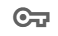 icon in the left menu bar of this Notebook
4. Click `+ Add new secret `
- Add OpenAI key:
  * Under Name copy paste: `OPENAI_KEY`
  * Under Value copy paste: OpenAI key you saved earlier

- Add HuggingFace key:
  * Under Name copy paste: `HF_KEY`
  * Under Value copy paste: HF key you saved earlier

5. Enable access to the keys for this notebook by toggling the radio buttons in the `Secrets` section.
6. Close the `Secrets` section once done.
7. Click `Run all` under the `Runtime` in top menu to execute this notebook.


#Basic Setup
**Install Frameworks**

`langchain`, `langchain_core`, and `langchain_community` are components of the LangChain framework.

`faiss-cpu` is Facebook AI's similarity search library, optimized for CPU usage.

`openai==1.56.2` and `langchain_openai` are the OpenAI Python client library and LangChain's OpenAI integration package respectively.

In [ ]:
%%capture
!pip install langchain langchain_core langchain_community faiss-cpu openai==1.56.2 langchain_openai

**Import Packages**



In [ ]:
import os
from google.colab import userdata
from typing import List, Dict, Any, Tuple
import requests
from langchain_core.documents import Document
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.embeddings import Embeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
import numpy as np
import time

**Project's Secret Keys Setup**

This code sets up authentication credentials by retrieving API keys from Colab's `Secrets` storage.

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY')
hfToken = userdata.get('HF_KEY')

# Configuration Dictionary

Contains settings for document processing and RAG system, including parameters for text chunking, embedding generation, document retrieval, model specifications, prompts used and API endpoints.

In [ ]:
defaultConfig = {
    # Document processing settings
    "chunkSize": 500,
    "chunkOverlap": 50,
    "userAgentHeader": "YourCompany-ResearchBot/1.0 (your@email.com)",

    # Embedding settings
    "embeddingApiUrl": "https://api-inference.huggingface.co/models/BAAI/bge-base-en-v1.5",
    "embeddingDim": 768,

    #Defalt document
    "defaultDocument" : Document(
        page_content = "This is a default document.",
        metadata = {"source": "default"}
    ),

    # Vector store settings
    "numRetrievedDocuments": 12,

    # Document formater settings
    "numSelectedDocuments": 5,

    # Model settings
    "ragAnswerModel": "gpt-4o",
    "ragAnswerModelTemperature": 0.7,

    # URLs to process
    "companyFilingUrls": [
        ("Tesla", "https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm")
    ],

    # RAG prompt template
    "ragPromptTemplate": """
    Give an answer for the `Question` using only the given `Context`. Use information relevant to the query from the entire context.
    Provide a detailed answer with thorough explanations, avoiding summaries.

    Question: {question}

    Context: {context}

    Answer:
    """
}


# Preprocessing Class
`FilingsPreProcessor` (Custom-defined class):
A custom class that downloads and preprocesses company filing documents from the web, splitting large filings into smaller text chunks for easier embedding and retrieval.

`__init __`:
Constructor method that initializes the preprocessor with configuration parameters for chunk size, overlap, and an internal dictionary to store text chunks used specificially for extracting director names.

`loadAndProcessFilings`:
Method that takes company filing URLs, downloads content, processes it into chunks, and stores the last 1000 characters for director names; returns processed documents and director name chunks.

- `Document` (Langchain class):
LangChain class representing a document with content and metadata, which is company name in this exercise.

- `WebBaseLoader` (Langchain class):
  * LangChain class that downloads content from the given 10-K company filing URLs with a custom User-Agent Header, which informs SEC website where the request is coming from and what kind of user agent it is. It's like introducing yourself when you enter a room, but for computer programs! This is often required for accessing web data, especially in responsible web scraping.

- `RecursiveCharacterTextSplitter` (Langchain class):
LangChain class that splits text documents into smaller chunks with specified size and overlap. It adds the company names as metadata for each chunk, then returns the processed chunks.

In [ ]:
class FilingsPreProcessor:
    def __init__(self, config: Dict[str, Any]):
        self.chunkSize = config["chunkSize"]
        self.chunkOverlap = config["chunkOverlap"]
        self.userAgentHeader = config["userAgentHeader"]

    # Using langchain class Document
    def loadAndProcessFilings(self, companyFilingUrls: List[Tuple[str, str]]) -> List[Document]:
        processedCompanyFilings = []

        for company, url in companyFilingUrls:
            try:
                # Using langchain class WebBaseLoader
                filingContent = WebBaseLoader(url, header_template = {'User-Agent': self.userAgentHeader}).load()

                # Using langchain class RecursiveCharacterTextSplitter
                splitFilingContent = RecursiveCharacterTextSplitter(
                    chunk_size = self.chunkSize,
                    chunk_overlap = self.chunkOverlap
                    ).transform_documents(filingContent)

                for split in splitFilingContent:
                    split.metadata.update({
                        'company': company,
                    })

                processedCompanyFilings.extend(splitFilingContent)

            except Exception as e:
                print(f"Error processing {url}: {str(e)}")
                continue

        return processedCompanyFilings

# Embedding class
`EmbeddingService` (Custom-defined class):
A custom class that inherits from LangChain's Embeddings class, providing text embedding functionality through an external API

`__init __`:
Constructor that initializes the service with API URL, headers, and embedding configuration
- Sets up the Hugging Face embedding API endpoint an headers
- Stores an instruction prefix that is added to user's query before embedding generation.
- Sets the embedding dimension size as per `embeddingDim` value in `defaultConfig` (e.g., 768)

`embed_documents`:
From LangChain's interface - transforms a list of texts into embeddings by removing newlines and calling _generateEmbeddings

`embed_query`:
From LangChain's interface - transforms a single query text into an embedding by adding instruction prefix and removing newlines

`_generateEmbeddings`:
Internal helper method that:
- Splits the input texts into batches (default size 30)
- Sends each batch to the embedding API with _sendBatchRequest
- Handles retries and times out if requests take too long
- Ensures each embedding matches the expected dimension (e.g., 768)
- Returns a list of embeddings

`_sendBatchRequest`:
Internal helper method that makes POST requests to the embedding API and handles the response

In [ ]:
class EmbeddingService(Embeddings):               # Using langchain class Embeddings
    def __init__(self, config: Dict[str, Any]):
        self.api_url = config["embeddingApiUrl"]
        self.headers = {"Authorization": f"Bearer {hfToken}"}
        self.queryInstruction = "Represent this question for searching relevant passages: "
        self.embeddingDim = config["embeddingDim"]

    def embed_documents(self, texts: list[str]) -> List[List[float]]:
        textsToEmbed = [text.replace("\n", " ") for text in texts]
        return self._generateEmbeddings(textsToEmbed)

    def embed_query(self, text: str) -> List[float]:
        textToEmbed = self.queryInstruction + text.replace("\n", " ")
        return self._generateEmbeddings([textToEmbed])[0]

    def _generateEmbeddings(self, texts: List[str]) -> List[List[float]]:
        results = [np.zeros(self.embeddingDim).tolist() for _ in range(len(texts))]
        batchSize = 30
        longRetries = 0

        batches = [(i, texts[i:i + batchSize]) for i in range(0, len(texts), batchSize)]

        for Id, batch in batches:
            startTime = time.time()

            while time.time() - startTime < 30:
                try:
                    response = self._sendBatchRequest(batch)

                    if not isinstance(response, list):
                        continue

                    break
                except Exception as e:
                    time.sleep(1)
                    continue

            if time.time() - startTime > 10:
                longRetries += 1
                if longRetries > 3:
                    print("Too many long retries, stopping embedding generation")
                    return results

            for j, embedding in enumerate(response):
                if isinstance(embedding, list) and len(embedding) == self.embeddingDim:
                    results[Id + j] = embedding
                else:
                    print(f"Invalid embedding format at index {Id + j}: {embedding[:100]}...")

        if len(texts) > 1:
            successful = sum(1 for emb in results if any(emb))
            print(f"Successfully embedded {successful}/{len(texts)} texts")

        return results

    def _sendBatchRequest(self, batch: List[str]) -> List[List[float]]:
        response = requests.post(
            self.api_url,
            headers = self.headers,
            json = {"inputs": batch}
        )
        if response.status_code != 200:
            raise ValueError(f"API returned status code {response.status_code}")
        return response.json()

# Vector DB class
`VectorStore` (Custom Class):
This custom class manages a FAISS-based vector store for storing and retrieving them by cosine similarity.

`__init __`:
Constructor that initializes a FAISS vector store with a default document and configures a retriever with number of documents to retrieve.
- `FAISS` (Langchain class):
A LangChain wrapper class for Facebook AI Similarity Search library. It manages vector database creation, indexes embeddings and retrieves embeddings similar to the queried embedding. Its `from_documents` function accepts a chunk/query, and an instance of `Embedding` Langchain class for generating embeddings for provided chunk/query.
- The VectorStore class creates a retriever using self.store.as_retriever(). This retriever is responsible for fetching relevant documents from the vector store based on a query's embedding.

`addDocuments`:
It adds new documents to the FAISS vector store created in `__init__`, accepting a list of Document objects as input
- `Document` (Langchain class):
 A LangChain document class is used to represent each chunk as a `Document` object.



In [ ]:
class VectorStore:
    def __init__(self, config, embeddingFunction):
        # Using langchain class FAISS
        self.store = FAISS.from_documents([config["defaultDocument"]], embeddingFunction)
        self.retriever = self.store.as_retriever(
            search_kwargs = {"k": config["numRetrievedDocuments"]}
        )

    def addDocuments(self,  documents: List[Document]) -> None:
        self.store.add_documents(documents)

# RAG chain class
`RAGChain` (Custom-defined class):
 A custom class implementing a Retrieval-Augmented Generation (RAG) system that combines document retrieval with language model generation by retrieving the most relevant documents and using them to generate and answer.

`__init __`:
Initializes the RAG chain with configuration and a vector store retriever

- Stores a reference to the `baseRetriever` (from the VectorStore class)
- `ChatOpenAI` (Langchain class):
 LangChain class for interfacing with OpenAI's chat models
- prompt is an instance of `PromptTemplate` (a LangChain class) to build the RAG prompt.
- Sets the number of documents to be selected from the vector store
- Builds the entire chain pipeline via `_makeChain()`

Q) Why did we use Langchain's `PromptTemplate` class instead of a string template directly?
- It ensures dynamic input substitution with validation, reducing the risk of formatting errors or missing placeholders.
- It integrates seamlessly with LangChain's modular components, enhancing composability in workflows and simplifying maintenance.

`query`:
The main interface method that processes a question through the entire RAG pipeline and returns the LLM-generated answer.

`_retrieveContext`:
- Retrieves relevant chunks for a given question using the base retriever from VectorStore class

- Uses `_formatDocs` to format retreived chunks into a string that can be used as context for the language model. `_formatDocs` does the following:
  * Selects only the first `self.numSelectedDocuments` chunks retrieved from vector store.
  *  `_getPrefix(doc)` extracts the company name added as metadata to each chunk in `loadAndProcessFilings`, and concatenates it to the text content of each chunk (`doc.page_content`).
  * Joins all the chunks into a single string.  It adds 2 line breaks `\n\n` as a seperator between two chunks.

`_makeChain`:
Constructs the processing pipeline using LangChain's Runnable interface components.

- `RunnableLambda` is a LangChain utility that wraps a callable Python function (in this case, _retrieveContext) and makes it compatible with LangChain pipelines. The output of this step is the retrieved chunks combined into a string generated by `retrieveContext`.
- `RunnablePassthrough` is a LangChain utility that simply passes the user's question to the next step in the pipeline without modifying it. This is useful when you need to include the question alongside the context in a prompt for generating response.
- Next step in pipeline replaces placeholder variables {context} and {question} in prompt instance with the retrieved context from `RunnableLambda` and the original question from `RunnablePassthrough`.
- `ChatOpenAI` is a LangChain interface for interacting with OpenAI's chat models. This component invokes the OpenAI language model (e.g., GPT-4) to generate a response based on the prompt.
- `StrOutputParser` is a LangChain utility that parses the raw output of the LLM (such as the model used via ChatOpenAI) into a clean string format.

In [ ]:
class RAGChain:
    def __init__(self, config: Dict[str, Any], baseRetriever: VectorStore):
        self.baseRetriever = baseRetriever
        self.llm = ChatOpenAI(model=config["ragAnswerModel"], temperature=config["ragAnswerModelTemperature"])
        self.prompt = PromptTemplate.from_template(config["ragPromptTemplate"])
        self.numSelectedDocuments = config["numSelectedDocuments"]

    def _retrieveContext(self, question: str) -> str:
        retrievedDocs = self.baseRetriever.invoke(question)
        return self._formatDocs(retrievedDocs)

    def _formatDocs(self, docs: List[Document]) -> str:
        def _getPrefix(doc):
            company = doc.__dict__.get('metadata', {}).get('company', '')
            return company

        return "\n\n".join(f"{_getPrefix(doc)}\n{doc.page_content}" for doc in docs[:self.numSelectedDocuments])

    def _makeChain(self):
        return (
            {
                "context": RunnableLambda(self._retrieveContext),
                "question": RunnablePassthrough()
            }
            | self.prompt
            | self.llm
            | StrOutputParser()
        )

    def query(self, question: str) -> str:
        return self._makeChain().invoke(question)

# PreProcessing Data

So far, we have defined the classes (blueprint) needed for implementing a simple RAG prototype on 10-K filings. These classes provide the foundational structure for tasks like data retrieval and processing. Next, we will create instances to operationalize these tasks and demonstrate preprocessing functionality.

In [ ]:
config = defaultConfig.copy() # Creates a separate copy of the default configuration dictionary (defaultConfig) so that any subsequent changes won't alter the original default settings.

## Chunking
* Creates a `FilingsPreProcessor` instance, responsible for downloading webpages and splitting filings into smaller, more manageable chunks.
* Uses the `loadAndProcessFilings` to load, split, and process the filing URLs listed in config["companyFilingUrls"].
* Returns chunks ready for indexing in Vector DB.


In [ ]:
preProcessorObj = FilingsPreProcessor(config)
processedFilings = preProcessorObj.loadAndProcessFilings(config["companyFilingUrls"])

## Embedding and Vector Storage
- Instantiates an `EmbeddingService` object, which provides text embedding functionality (via the Hugging Face Inference API in this example).
- Instantiates a `VectorStore` object
- Builds a VectorStore object that internally uses a FAISS store to index and retrieve documents based on vector similarity.
- Uses embedding object created earlier to generate embeddings of chunks added by `addDocuments`.


In [ ]:
embeddingServiceObj = EmbeddingService(config)
vectorStoreObj = VectorStore(config, embeddingServiceObj)
vectorStoreObj.addDocuments(processedFilings)

Successfully embedded 942/942 texts


# User Query Processing

## RAG Chain pipeline
This pipeline assembles all the necessary pieces:
- Takes the configuration settings (`config`).
- Connects the RAG pipeline to the vector store through the retriever (`vectorStoreObj.retriever`) and fetches the most relevant chunks based on the user query passed to `ragObj.query`.
- Packages the entire pipeline into a single object (`ragObj`) that represents your complete RAG system. `ragObj` is an instance of the `RAGChain`class. You can think of it like a container or a handle that is used to interact with the entire RAG system.

In [ ]:
ragObj = RAGChain(config, vectorStoreObj.retriever)

## Pass User Query
This is where you pass the user's query to RAG pipeline.

In [ ]:
print(ragObj.query("What technological advancements were made in the batteries used in Tesla's Electric Vehicles?"))

Tesla has made significant technological advancements in the batteries used in its electric vehicles (EVs) by focusing on both the development of new battery cells and the enhancement of manufacturing processes. The company has developed a proprietary lithium-ion battery cell, which is aimed at achieving higher energy density while reducing costs. This advancement is crucial as it allows Tesla to produce batteries that can store more energy in the same space, thereby improving the range and efficiency of their EVs.

Furthermore, Tesla has invested heavily in research and development (R&D) capabilities for battery cells, packs, and systems. This includes extensive knowledge of lithium-ion cell chemistry types and their performance characteristics, which helps in optimizing the energy density and overall performance of the batteries.

In addition to cell development, Tesla has also improved its battery manufacturing processes. These improvements are likely aimed at increasing production 

## Final Response Analysis
The final response lists the following advancments:


1.  Development of a new proprietary lithium-ion battery cell
2.  Improved manufacturing processes for the batteries.

The response explains these developments and how they impact Tesla.

You can see how RAG is able to answer basic queries that by retriving the information required.